## 1. Import Libraries and Set Device

In [69]:
# ========== Standard Libraries ==========
import csv
import os
import time
import warnings
from datetime import datetime
import random

# ========== Data Handling & ML ==========
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# ========== Deep Learning (PyTorch) ==========
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms

# ========== Image Processing & Visualization ==========
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# ========== Utilities ==========
from tqdm import tqdm
import joblib


In [70]:
# Set the device for PyTorch computations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print device information
print(f"Using {device} device")
print(f"CUDA Available: {torch.cuda.is_available()}")

# If CUDA is available, print additional details
if torch.cuda.is_available():
    print(f"Number of CUDA Devices: {torch.cuda.device_count()}")
    print(f"Current CUDA Device: {torch.cuda.current_device()}")
    print(f"CUDA Device Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

Using cuda device
CUDA Available: True
Number of CUDA Devices: 1
Current CUDA Device: 0
CUDA Device Name: NVIDIA GeForce RTX 4060 Ti


## 2. Data Loading and Preprocessing

In [71]:
root_dir = "lung_colon_image_set"
image_paths = []
multi_labels = []

label_mapping = {
    'lung_n': 0, 'lung_aca': 1, 'lung_scc': 2,
    'colon_n': 3, 'colon_aca': 4
}

class_names = list(label_mapping.keys())

for subfolder in ['lung_image_sets/lung_n', 'lung_image_sets/lung_aca', 'lung_image_sets/lung_scc',
                  'colon_image_sets/colon_n', 'colon_image_sets/colon_aca']:
    class_dir = os.path.join(root_dir, subfolder)
    class_name = subfolder.split('/')[-1]

    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        image_paths.append(img_path)
        multi_labels.append(label_mapping[class_name])

print(f"Total Image: {len(image_paths)}")


Total Image: 25000


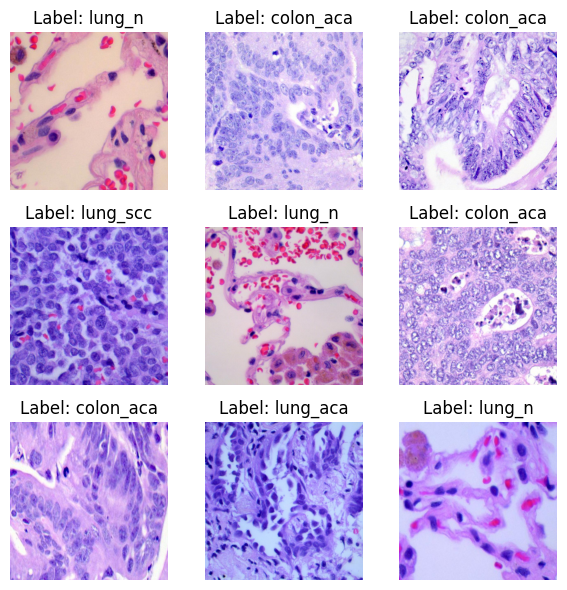

In [72]:
indices = random.sample(range(len(image_paths)), 9)

# Create a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
axes = axes.flatten()

for i, idx in enumerate(indices):
    img_path = image_paths[idx]
    label = multi_labels[idx]
    img = Image.open(img_path) 
    ax = axes[i]
    ax.imshow(img)
    ax.set_title(f"Label: {class_names[label]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Boyutlandırma (zorunlu)
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.2),  # Daha büyük kernel ve yüksek olasılık
    transforms.RandomApply([  # Daha geniş açı, daha büyük ölçek ve çeviri
        transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.75, 1.25))
    ], p=0.2),  # Yüksek olasılıkla uygulama
    transforms.RandomPerspective(distortion_scale=0.5, p=0.2),  # Yüksek bozulma ve olasılık
    transforms.RandomHorizontalFlip(p=0.2),  # Yatay flip
    transforms.RandomVerticalFlip(p=0.2),  # Dikey flip
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.3),  # Yüksek renk varyasyonu
    transforms.RandomRotation(degrees=30),  # Döndürme (0-45 derece)
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Rastgele kırpma ve yeniden boyutlandırma
    transforms.RandomInvert(),  # Görüntü renklerini tersine çevirme
    transforms.RandomAutocontrast(),  # Kontrast artırma
    transforms.RandomEqualize(),  # Görüntü eşitleme
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Regular transform for test/validation data (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [74]:
class FeatureDataset(Dataset):
    def __init__(self, image_paths, multi_labels, transform=None):
        self.image_paths = image_paths
        self.multi_labels = multi_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.multi_labels[idx]


In [75]:
X_train, X_test, y_train, y_test = train_test_split(
    image_paths, 
    multi_labels, 
    test_size=0.2, 
    random_state=42, 
    stratify=multi_labels
)

# Create datasets with respective transformations
train_dataset = FeatureDataset(X_train, y_train, transform=train_transform)
test_dataset = FeatureDataset(X_test, y_test, transform=test_transform)

# Create data loaders for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## 3. EfficientNetB3 For Feature Extraction

In [76]:
model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
model.classifier = torch.nn.Identity() 
model = model.to(device)
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [77]:
def extract_features(dataloader, model, device='cuda'):
    all_features = []
    all_labels = []

    print("Extracting features...")
    start_time = time.time()

    model.eval()  # Ensure the model is in evaluation mode

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            features = model(inputs)
            all_features.append(features.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Feature extraction completed in {elapsed:.2f} seconds.")

    return np.concatenate(all_features), np.array(all_labels)

In [ ]:
X_train_feat, y_train = extract_features(train_loader, model, device)
X_test_feat, y_test = extract_features(test_loader, model, device)

Extracting features...


In [ ]:
print(f"Train Feature Shape: {X_train_feat.shape}")
print(f"Test Feature Shape: {X_test_feat.shape}")
print(f"Train Label Shape: {y_train.shape}")
print(f"Test Label Shape: {y_test.shape}")

Train Feature Shape: (20000, 1536)
Test Feature Shape: (5000, 1536)
Train Label Shape: (20000,)
Test Label Shape: (5000,)


In [ ]:
# 1. Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_test_scaled = scaler.transform(X_test_feat)

# 2. Başlangıç boyutunu yazdır
original_feature_count = X_train_scaled.shape[1]
print(f"Original number of features: {original_feature_count}")

# 3. %90 varyansı sağlayacak bileşen sayısını bul
pca_temp = PCA()
pca_temp.fit(X_train_scaled)
cumulative_variance = np.cumsum(pca_temp.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components to preserve 90% variance: {n_components_90}")

# 4. PCA ile indirgeme (90% varyansı koruyacak şekilde)
pca = PCA(n_components=n_components_90, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Final number of PCA features: {X_train_pca.shape[1]}")

Original number of features: 1536
Number of components to preserve 90% variance: 523
Final number of PCA features: 523


## 4. Needed Function For Test and Eval

In [ ]:
def filter_dataset_by_class(X_train_pca, y_train, X_test_pca, y_test, class_range):
    # Get indices of the classes within the class_range
    train_indices = np.where(np.isin(y_train, class_range))[0]
    test_indices = np.where(np.isin(y_test, class_range))[0]

    # Filter the data based on the selected class_range
    X_train = X_train_pca[train_indices]
    y_train_filtered = y_train[train_indices] - min(class_range)

    X_test = X_test_pca[test_indices]
    y_test_filtered = y_test[test_indices] - min(class_range)

    return X_train, y_train_filtered, X_test, y_test_filtered


In [ ]:
def save_best_model(model, model_name, task_name, accuracy, f1_score, precision, recall):
    # Create the models directory if it doesn't exist
    models_dir = "models"
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    # Save the model to a joblib file
    filename = f"{models_dir}/{task_name.replace(' ', '_').lower()}_{model_name.replace(' ', '_').lower()}.joblib"
    joblib.dump(model, filename)
    print(f"Saved best model '{model_name}' for {task_name} as: {filename}")

    # Log the model performance to a CSV file
    log_filename = f"{models_dir}/model_performance.csv"

    # Prepare performance data
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    performance_data = {
        'timestamp': timestamp,
        'model_name': model_name,
        'accuracy': accuracy,
        'f1_score': f1_score,
        'precision': precision,
        'recall': recall
    }

    # Check if the log file exists, if not, create it with headers
    if not os.path.exists(log_filename):
        df = pd.DataFrame(columns=['timestamp', 'model_name', 'accuracy', 'f1_score', 'precision', 'recall'])
        df.to_csv(log_filename, index=False)

    # Append the performance data to the CSV file
    df = pd.DataFrame([performance_data])
    df.to_csv(log_filename, mode='a', header=False, index=False)
    print(f"Saved model performance to: {log_filename}")

In [ ]:
def train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test, class_names):

    # Train
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f"\n--- {model_name} ---")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    print("Accuracy:", acc)
    print("F1 Score (weighted):", f1)
    print("Precision (weighted):", precision)
    print("Recall (weighted):", recall) 

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    return model_name, acc, f1, precision, recall

In [ ]:
def evaluate_cancer_classifiers(X_train_pca, y_train, X_test_pca, y_test,
                                 class_range, class_names, task_name="Cancer Classification"):
    
    # Filter data based on class_range
    X_train, y_train_filtered, X_test, y_test_filtered = filter_dataset_by_class(
        X_train_pca, y_train, X_test_pca, y_test, class_range
    )

    # Automatically determine number of classes
    n_classes = len(np.unique(y_train_filtered))

    # Dynamically configure XGBoost parameters
    if n_classes == 2:
        xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    else:
        xgb_model = XGBClassifier(use_label_encoder=False,
                                  objective='multi:softprob',
                                  num_class=n_classes,
                                  eval_metric='mlogloss')

    # Define the models
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "SVM (rbf)": SVC(kernel='rbf', probability=True),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "XGBoost": xgb_model
    }

    acc_list, f1_list, precision_list, recall_list = [], [], [], []
    training_times = []
    trained_models = {}

    print(f"\n========== {task_name} Evaluation ==========")
    print(f"Classes: {class_names}")

    # Evaluate all models
    for name, model in models.items():
        start_time = time.time()
        acc_model, acc, f1, precision, recall = train_and_evaluate_model(
            model, name, X_train, y_train_filtered, X_test, y_test_filtered, class_names
        )
        end_time = time.time()
        training_time = end_time - start_time

        acc_list.append((acc_model, acc))
        f1_list.append((acc_model, f1))
        precision_list.append((acc_model, precision))
        recall_list.append((acc_model, recall))
        training_times.append(training_time)
        trained_models[name] = model
        print(f"Training time for {name}: {training_time:.2f} seconds")

    # Determine best model by F1 score
    best_model_name, _ = max(f1_list, key=lambda x: x[1])
    best_model = trained_models[best_model_name]

    best_accuracy = dict(acc_list)[best_model_name]
    best_f1 = dict(f1_list)[best_model_name]
    best_precision = dict(precision_list)[best_model_name]
    best_recall = dict(recall_list)[best_model_name]

    save_best_model(best_model, best_model_name, task_name,
                    best_accuracy, best_f1, best_precision, best_recall)

    # Accuracy & F1 visualization
    model_names = [x[0] for x in acc_list]
    acc_values = [x[1] for x in acc_list]
    f1_values = [x[1] for x in f1_list]

    x = np.arange(len(model_names))
    width = 0.35

    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, acc_values, width, label='Accuracy', color='skyblue')
    plt.bar(x + width/2, f1_values, width, label='F1 Score', color='salmon')
    plt.xticks(x, model_names, rotation=45)
    plt.ylabel("Score")
    plt.title(f"{task_name} - Model Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Training time visualization
    plt.figure(figsize=(8, 5))
    plt.bar(model_names, training_times, color='lightgreen')
    plt.xlabel("Model")
    plt.ylabel("Training Time (seconds)")
    plt.title(f"{task_name} - Training Time Comparison")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("\nClassification and model saving completed.")
    
    return best_model


## 5. Lung Cancer Ops


========== Lung Cancer Evaluation ==========
Classes: ['lung_n', 'lung_aca', 'lung_scc']

--- Random Forest ---
Classification Report:
              precision    recall  f1-score   support

      lung_n       0.92      0.99      0.96      1000
    lung_aca       0.92      0.85      0.88      1000
    lung_scc       0.93      0.94      0.93      1000

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000

Accuracy: 0.926
F1 Score (weighted): 0.925097565520607
Precision (weighted): 0.9259507675786746
Recall (weighted): 0.926


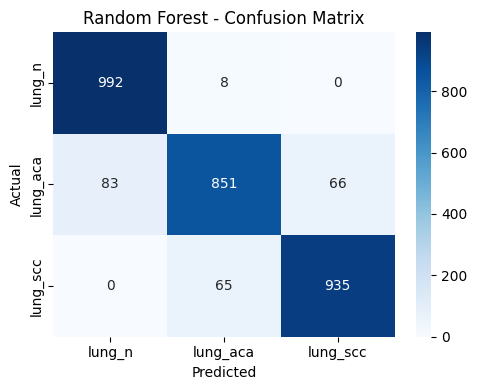

Training time for Random Forest: 24.04 seconds

--- Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

      lung_n       0.99      1.00      0.99      1000
    lung_aca       0.98      0.95      0.96      1000
    lung_scc       0.96      0.98      0.97      1000

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000

Accuracy: 0.9756666666666667
F1 Score (weighted): 0.975590705291855
Precision (weighted): 0.9757601250523285
Recall (weighted): 0.9756666666666667


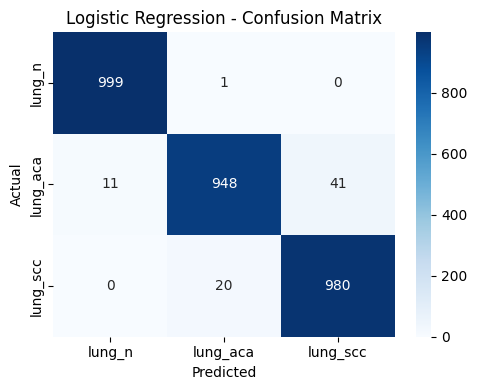

Training time for Logistic Regression: 3.61 seconds

--- SVM (rbf) ---
Classification Report:
              precision    recall  f1-score   support

      lung_n       0.99      1.00      1.00      1000
    lung_aca       0.99      0.95      0.97      1000
    lung_scc       0.96      0.99      0.98      1000

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000

Accuracy: 0.9813333333333333
F1 Score (weighted): 0.9812689334050707
Precision (weighted): 0.981545948873114
Recall (weighted): 0.9813333333333333


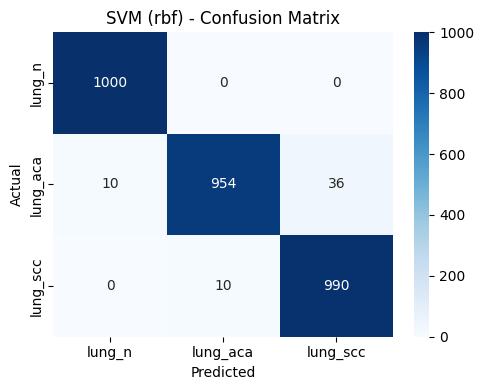

Training time for SVM (rbf): 45.61 seconds

--- Decision Tree ---
Classification Report:
              precision    recall  f1-score   support

      lung_n       0.89      0.95      0.92      1000
    lung_aca       0.82      0.74      0.78      1000
    lung_scc       0.86      0.88      0.87      1000

    accuracy                           0.86      3000
   macro avg       0.85      0.86      0.85      3000
weighted avg       0.85      0.86      0.85      3000

Accuracy: 0.856
F1 Score (weighted): 0.8539925550935666
Precision (weighted): 0.8540194586767775
Recall (weighted): 0.856


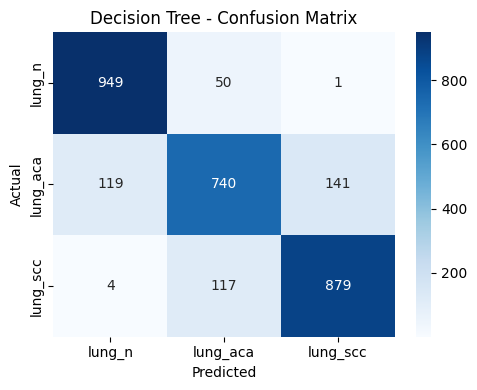

Training time for Decision Tree: 9.97 seconds


c:\Users\burakdogan\Desktop\Ders\DeepLearning\LungColon\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [05:09:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost ---
Classification Report:
              precision    recall  f1-score   support

      lung_n       0.95      1.00      0.98      1000
    lung_aca       0.97      0.90      0.93      1000
    lung_scc       0.95      0.97      0.96      1000

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000

Accuracy: 0.9563333333333334
F1 Score (weighted): 0.9558780625648801
Precision (weighted): 0.956713539029357
Recall (weighted): 0.9563333333333334


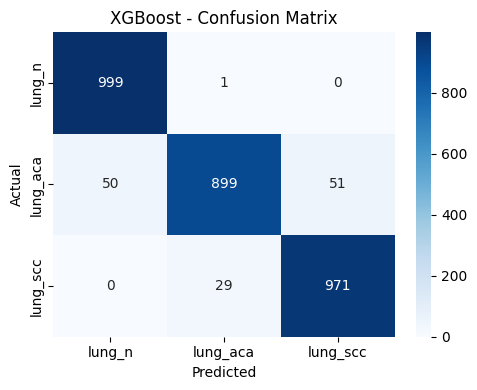

Training time for XGBoost: 11.40 seconds
Saved best model 'SVM (rbf)' for Lung Cancer as: models/lung_cancer_svm_(rbf).joblib
Saved model performance to: models/model_performance.csv


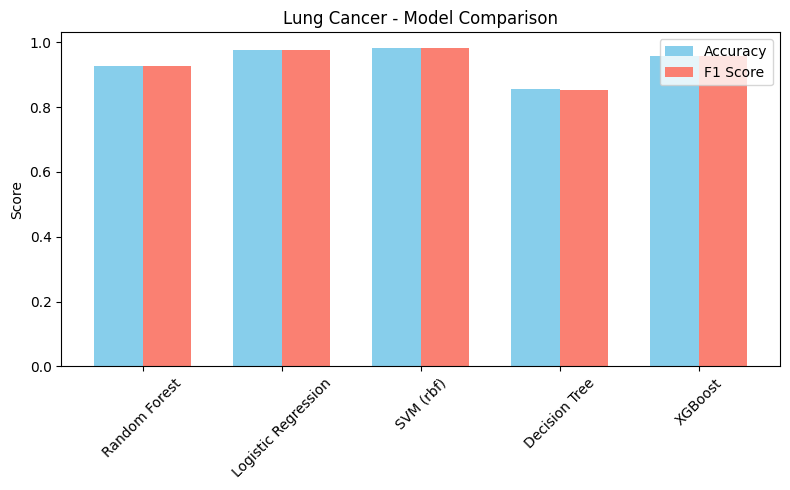

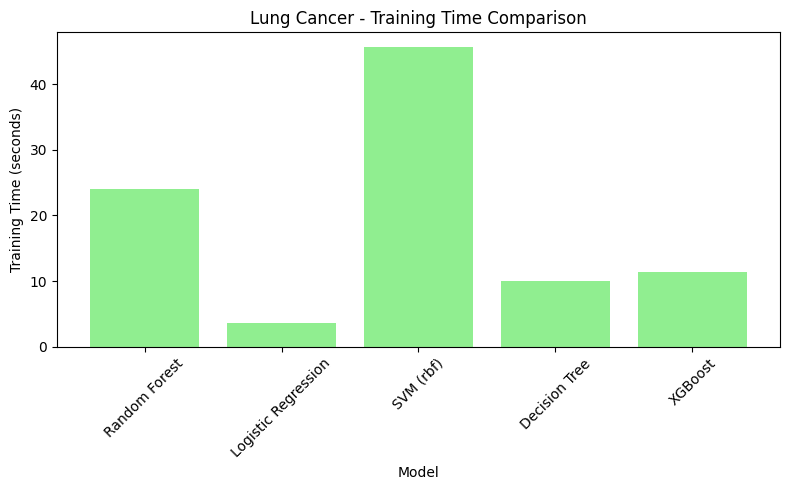


Classification and model saving completed.


In [ ]:
best_lung_model = evaluate_cancer_classifiers(
    X_train_pca, y_train,  # Use scaled features
    X_test_pca, y_test,  # Use scaled test features
    class_range=range(0, 3),
    class_names=['lung_n', 'lung_aca', 'lung_scc'],
    task_name="Lung Cancer"
)

## 6. Colon Cancer Ops


========== Colon Cancer Evaluation ==========
Classes: ['colon_n', 'colon_aca']

--- Random Forest ---
Classification Report:
              precision    recall  f1-score   support

     colon_n       0.99      0.97      0.98      1000
   colon_aca       0.97      0.99      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000

Accuracy: 0.9795
F1 Score (weighted): 0.9794967963744335
Precision (weighted): 0.9797998749218262
Recall (weighted): 0.9795


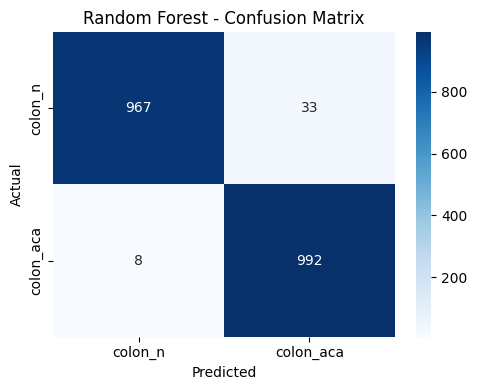

Training time for Random Forest: 16.05 seconds

--- Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

     colon_n       1.00      1.00      1.00      1000
   colon_aca       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Accuracy: 0.9975
F1 Score (weighted): 0.9974999943749874
Precision (weighted): 0.9975044775402979
Recall (weighted): 0.9975


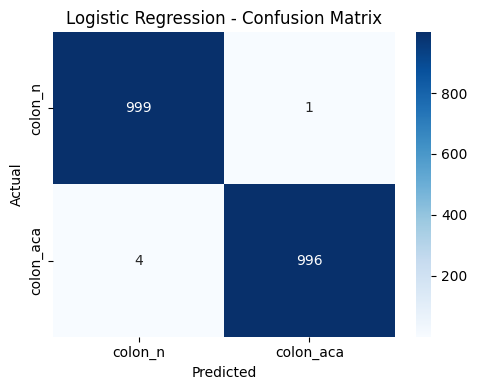

Training time for Logistic Regression: 0.16 seconds

--- SVM (rbf) ---
Classification Report:
              precision    recall  f1-score   support

     colon_n       1.00      1.00      1.00      1000
   colon_aca       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Accuracy: 0.998
F1 Score (weighted): 0.998
Precision (weighted): 0.998
Recall (weighted): 0.998


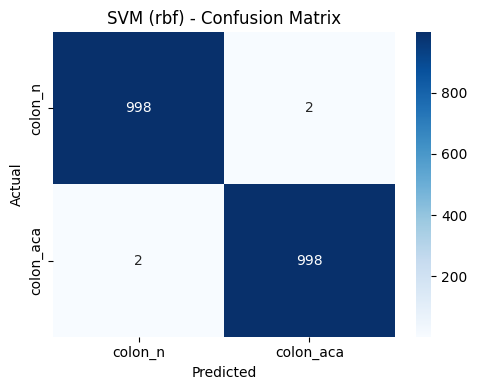

Training time for SVM (rbf): 11.04 seconds

--- Decision Tree ---
Classification Report:
              precision    recall  f1-score   support

     colon_n       0.92      0.93      0.93      1000
   colon_aca       0.93      0.92      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000

Accuracy: 0.9245
F1 Score (weighted): 0.9244945447308569
Precision (weighted): 0.9246227159649139
Recall (weighted): 0.9245


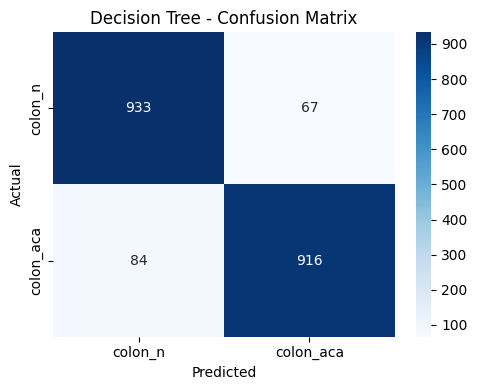

Training time for Decision Tree: 8.33 seconds


c:\Users\burakdogan\Desktop\Ders\DeepLearning\LungColon\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [05:09:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost ---
Classification Report:
              precision    recall  f1-score   support

     colon_n       0.99      0.98      0.99      1000
   colon_aca       0.98      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

Accuracy: 0.987
F1 Score (weighted): 0.986999791996672
Precision (weighted): 0.9870311699948797
Recall (weighted): 0.987


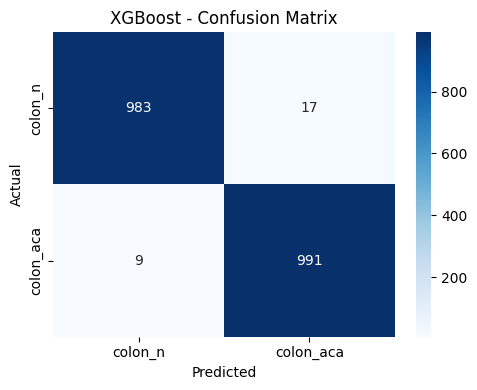

Training time for XGBoost: 2.57 seconds
Saved best model 'SVM (rbf)' for Colon Cancer as: models/colon_cancer_svm_(rbf).joblib
Saved model performance to: models/model_performance.csv


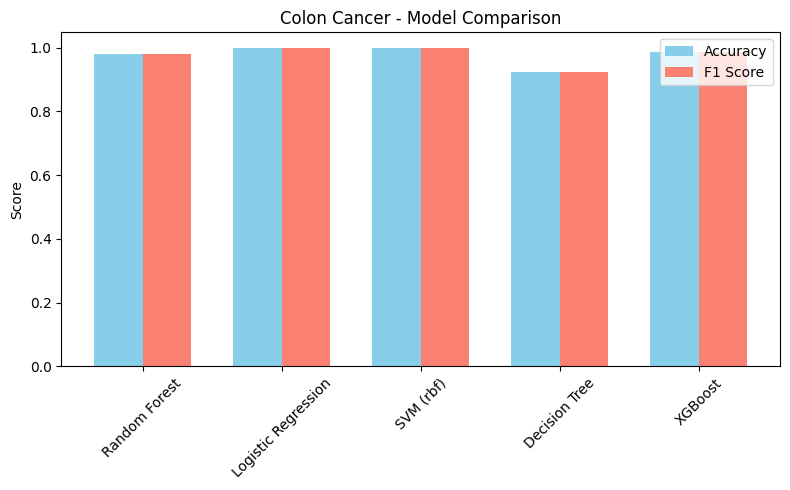

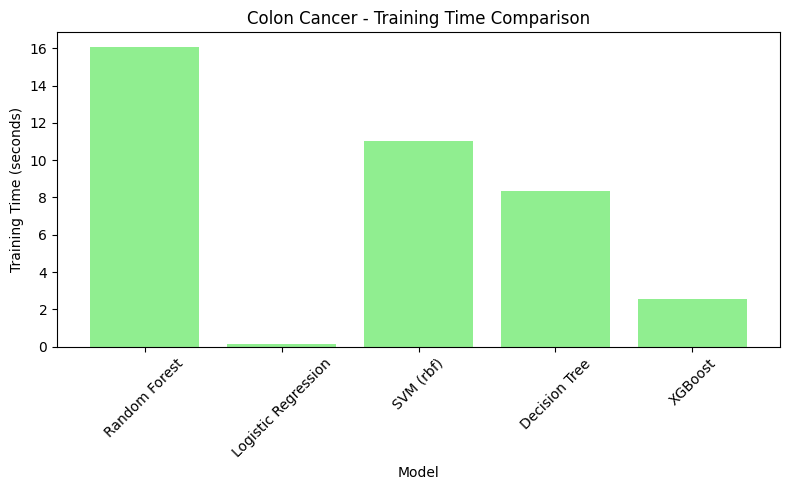


Classification and model saving completed.


In [ ]:
best_colon_model = evaluate_cancer_classifiers(
    X_train_pca, y_train,  # Use scaled features
    X_test_pca, y_test,  # Use scaled test features
    class_range=range(3, 5),
    class_names=['colon_n', 'colon_aca'],
    task_name="Colon Cancer"
)